In [168]:
import pywt
import numpy as np
import matplotlib.pyplot as plt
from physioex.data import PhysioExDataset

# dataset sampling frequency 100Hz
data = PhysioExDataset(
    datasets = ["sleepedf"],
    preprocessing = "raw",  
    selected_channels = ["EEG", "EOG", "EMG"],     
    data_folder = "./data",
)

# getting a specific sample
signal, label = data[10000]

# number of 30s window epochs
print(f"Number of epochs in night {len(data)}")

print(f"Epoch shape {signal.shape}") # 21 sequences, 3 channels, 3000 samples (30s * sampling frequency)
print(f"Epoch classification {label.shape}")

# first sequence of epoch 10000
seq = signal[0]

Number of epochs in night 192884
Epoch shape torch.Size([21, 3, 3000])
Epoch classification torch.Size([21])


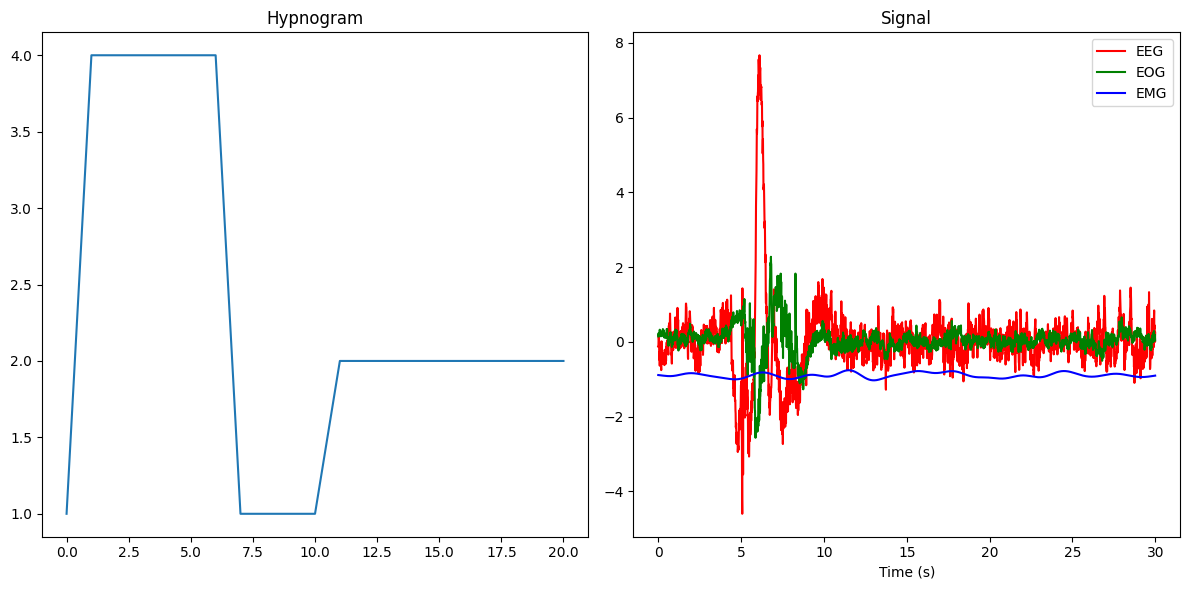

In [169]:
# plot the graphs in a 1x2 grid
fig, axs = plt.subplots(1, 2, figsize=(12, 6))

# plot the hypnogram
axs[0].set_title('Hypnogram')
axs[0].plot(label)

# plot the first 30s window
axs[1].set_title('Signal')
axs[1].plot(seq[0], 'r', label='EEG')
axs[1].plot(seq[1], 'g', label='EOG')
axs[1].plot(seq[2], 'b', label='EMG')
axs[1].legend()

# change x-axis to seconds
axs[1].set_xticks(np.arange(0, 3001, 500), np.arange(0, 31, 5))
axs[1].set_xlabel('Time (s)')

plt.tight_layout()
plt.show()



In [170]:
# wavelet families
print(pywt.families())

['haar', 'db', 'sym', 'coif', 'bior', 'rbio', 'dmey', 'gaus', 'mexh', 'morl', 'cgau', 'shan', 'fbsp', 'cmor']


In [171]:
cont_families = []
disc_families = []
for family in pywt.families():
    # create a wavelet object based on its name
    wavelet_name = pywt.wavelist(family)[0]
    if wavelet_name in pywt.wavelist(kind='continuous'):
        cont_families.append(family)
        # w = pywt.ContinuousWavelet(wavelet_name)
    if wavelet_name in pywt.wavelist(kind='discrete'):
        disc_families.append(family)
        # w = pywt.Wavelet(wavelet_name)
    # print(w)

print(cont_families)
print(disc_families)

['gaus', 'mexh', 'morl', 'cgau', 'shan', 'fbsp', 'cmor']
['haar', 'db', 'sym', 'coif', 'bior', 'rbio', 'dmey']


In [172]:
# compute WT of the signal
def compute_cwt(signal, fs, scales, wavelet="morl"):
    """
    Computes the wavelet transform (CWT or DWT) of a signal.

    :param signal: Input signal
    :param fs: Sampling frequency of the signal
    :param scales: Scales to use in the WT
    :param wavelet: Wavelet to use in the WT
    :return: CWT coefficients
    """
    # Compute the CWT
    coeffs, freq = pywt.cwt(data=signal, scales=scales, wavelet=wavelet, sampling_period=1/fs)
    
    return coeffs, freq

In [173]:
def compute_dwt(seq, wavelet="db4", level=3, duration=30):
    """
    Computes the discrete wavelet transform (DWT) of a signal.

    :param seq: Input signal
    :param wavelet: Wavelet to use in the DWT
    :param level: Level of decomposition
    :return: DWT coefficients
    """
    # Compute the DWT
    coeffs = pywt.wavedec(data=seq[:duration], wavelet=wavelet, level=level)
    return coeffs

In [174]:
def plot_cwt(coeffs, scales, duration=30, wavelet="morl"):
    # plot the cwt
    plt.figure(figsize=(10, 5))
    plt.imshow(np.abs(coeffs), aspect='auto', extent=[0, duration, scales[-1], scales[0]], cmap='jet')
    # fix the magnitude colorbar range
    plt.clim([0, 30])
    plt.colorbar(label="Magnitude")
    # set the y-axis to log scale in numerical values
    # plt.yscale('log', base=2)
    plt.ylabel("Frequency (Hz)")
    plt.xlabel("Time (s)")
    plt.title(f"PyWavelets Wavelet Transform {wavelet} Scalogram")
    plt.show()


In [175]:
def plot_dwt(coeffs, signal):
    plt.figure(figsize=(8, 6))
    plt.subplot(5, 1, 1)
    plt.plot(signal, label="Original Signal")
    plt.legend()

    for i, coeff in enumerate(coeffs):
        plt.subplot(5, 1, i + 2)
        plt.plot(coeff, label=f"Level {i} Approximation" if i == 0 else f"Level {i} Detail")
        plt.legend()

    plt.tight_layout()
    plt.show()

In [176]:
def plot_scaleogram(coeffs, wavelet="db4", level=3, duration=30):
    """
    Plots the 2D scaleogram from the wavelet decomposition coefficients.

    Parameters:
    coeffs (list): List of wavelet decomposition coefficients.
    wavelet (str): Wavelet used for the decomposition.
    level (int): Level of decomposition.
    """

    # Create a 2D array for the scaleogram
    scaleogram = np.zeros((level + 1, duration))
    
    # Fill the scaleogram with coefficients
    for i, coeff in enumerate(coeffs):
        scaleogram[i, :len(coeff)] = coeff
    
    # Calculate the frequencies for each level
    frequencies = pywt.scale2frequency(wavelet, np.arange(1, level + 2)) / (1.0 / duration)
    
    # Plot the scaleogram
    fig, ax = plt.subplots(figsize=(10, 6))
    cax = ax.imshow(scaleogram, aspect='auto', cmap='viridis', extent=[0, duration, frequencies[-1], frequencies[0]])
    ax.set_yscale('log', base=2)
    ax.set_title(f'Scaleogram using {wavelet} wavelet at level {level}')
    ax.set_xlabel('Time')
    ax.set_ylabel('Frequency')
    fig.colorbar(cax, ax=ax, label='Coefficient Magnitude')
    plt.show()

Wavelet: gaus1, Central frequency: 0.2 Hz
[40.          5.          2.5         1.53846154  0.66666667  0.4       ]


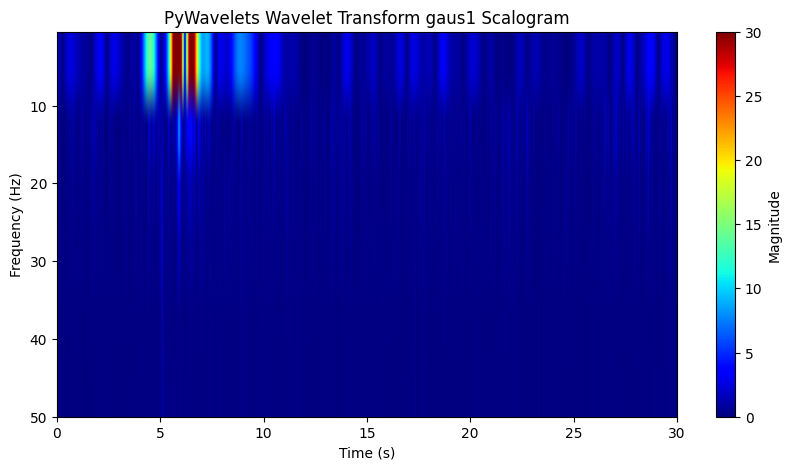

Wavelet: mexh, Central frequency: 0.25 Hz
[50.          6.25        3.125       1.92307692  0.83333333  0.5       ]


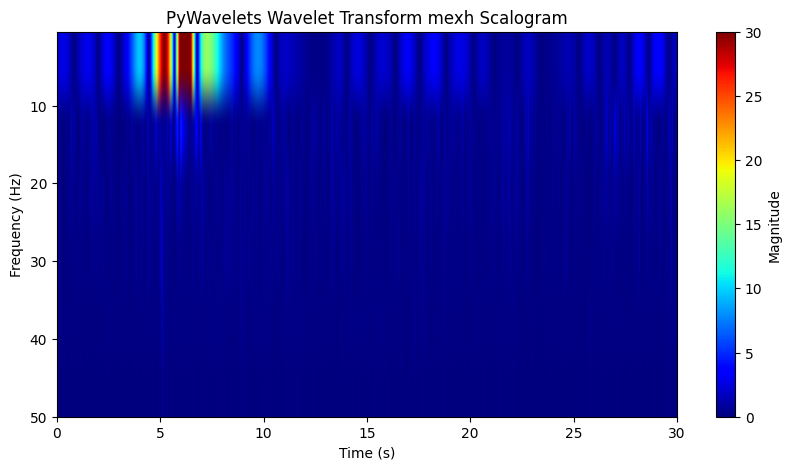

Wavelet: morl, Central frequency: 0.8125 Hz
[162.5         20.3125      10.15625      6.25         2.70833333
   1.625     ]


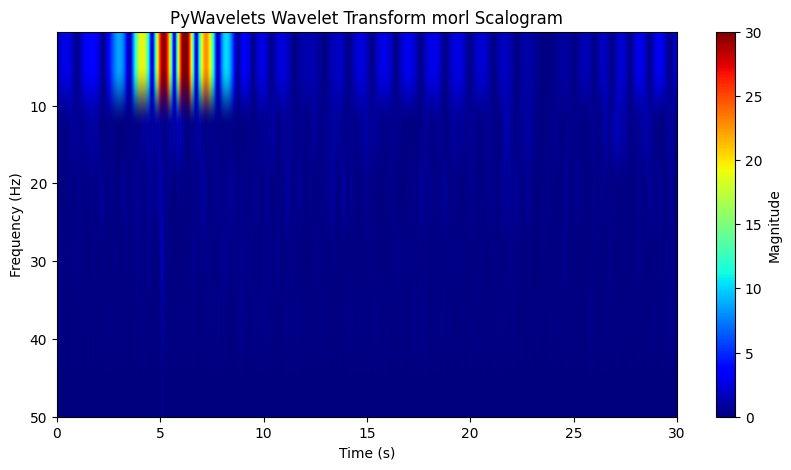

Wavelet: cgau1, Central frequency: 0.3 Hz
[60.          7.5         3.75        2.30769231  1.          0.6       ]


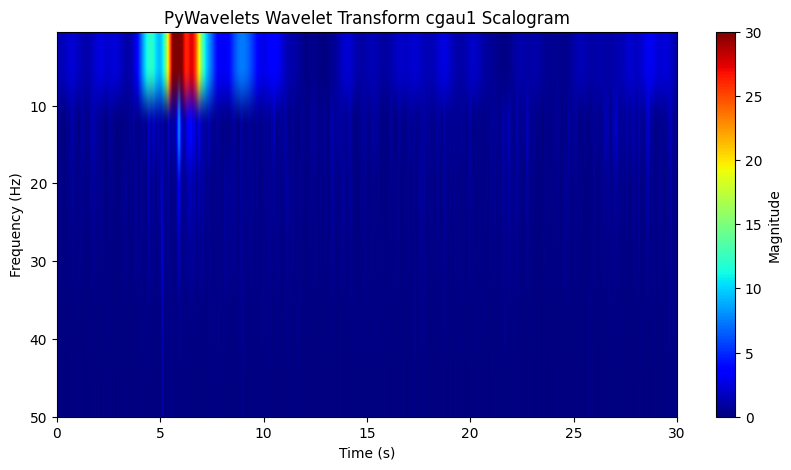

Wavelet: shan, Central frequency: 0.775 Hz
[155.          19.375        9.6875       5.96153846   2.58333333
   1.55      ]


/Users/alicia/Documents/Master/TFM/learnable-masks-explainability-time-series/.env/lib/python3.10/site-packages/pywt/_functions.py:141: FutureWarning: Wavelets from the family shan, without parameters specified in the name are deprecated. The name should follow the format shanB-C, where B and C are floats representing the bandwidth frequency and center frequency, respectively (example, for backward compatibility: shan = shan0.5-1.0).
  wavelet = DiscreteContinuousWavelet(wavelet)
/Users/alicia/Documents/Master/TFM/learnable-masks-explainability-time-series/.env/lib/python3.10/site-packages/pywt/_cwt.py:117: FutureWarning: Wavelets from the family shan, without parameters specified in the name are deprecated. The name should follow the format shanB-C, where B and C are floats representing the bandwidth frequency and center frequency, respectively (example, for backward compatibility: shan = shan0.5-1.0).
  wavelet = DiscreteContinuousWavelet(wavelet)


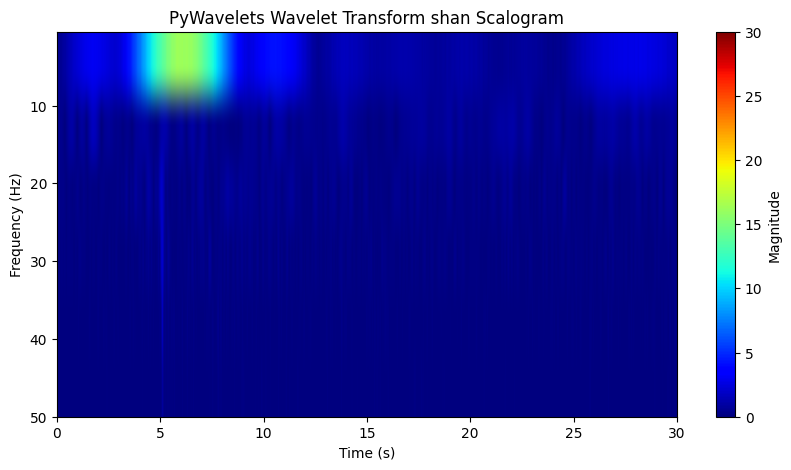

Wavelet: fbsp, Central frequency: 0.5 Hz
[100.          12.5          6.25         3.84615385   1.66666667
   1.        ]


/Users/alicia/Documents/Master/TFM/learnable-masks-explainability-time-series/.env/lib/python3.10/site-packages/pywt/_functions.py:141: FutureWarning: Wavelets of family fbsp, without parameters specified in the name are deprecated.  The name should follow the format fbspM-B-C where M is the spline order and B, C are floats representing the bandwidth frequency and center frequency, respectively (example, for backward compatibility: fbsp = fbsp2-1.0-0.5).
  wavelet = DiscreteContinuousWavelet(wavelet)
/Users/alicia/Documents/Master/TFM/learnable-masks-explainability-time-series/.env/lib/python3.10/site-packages/pywt/_cwt.py:117: FutureWarning: Wavelets of family fbsp, without parameters specified in the name are deprecated.  The name should follow the format fbspM-B-C where M is the spline order and B, C are floats representing the bandwidth frequency and center frequency, respectively (example, for backward compatibility: fbsp = fbsp2-1.0-0.5).
  wavelet = DiscreteContinuousWavelet(wav

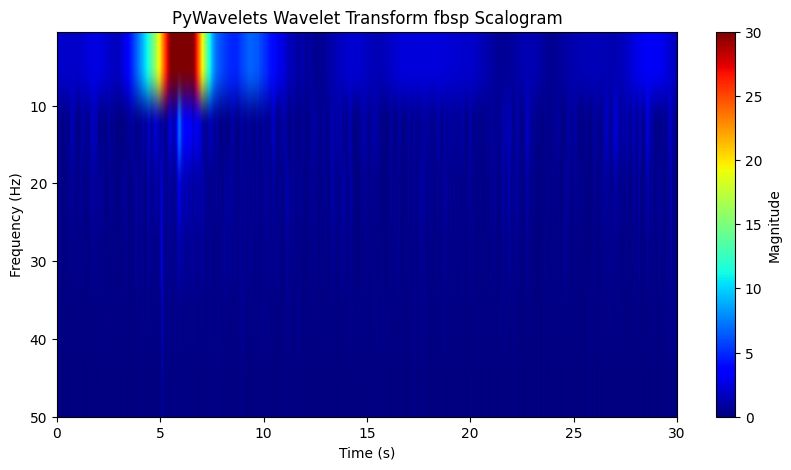

/Users/alicia/Documents/Master/TFM/learnable-masks-explainability-time-series/.env/lib/python3.10/site-packages/pywt/_functions.py:141: FutureWarning: Wavelets from the family cmor, without parameters specified in the name are deprecated. The name should follow the format cmorB-C, where B and C are floats representing the bandwidth frequency and center frequency, respectively (example, for backward compatibility: cmor = cmor1.0-0.5).
  wavelet = DiscreteContinuousWavelet(wavelet)
/Users/alicia/Documents/Master/TFM/learnable-masks-explainability-time-series/.env/lib/python3.10/site-packages/pywt/_cwt.py:117: FutureWarning: Wavelets from the family cmor, without parameters specified in the name are deprecated. The name should follow the format cmorB-C, where B and C are floats representing the bandwidth frequency and center frequency, respectively (example, for backward compatibility: cmor = cmor1.0-0.5).
  wavelet = DiscreteContinuousWavelet(wavelet)


Wavelet: cmor, Central frequency: 0.5 Hz
[100.          12.5          6.25         3.84615385   1.66666667
   1.        ]


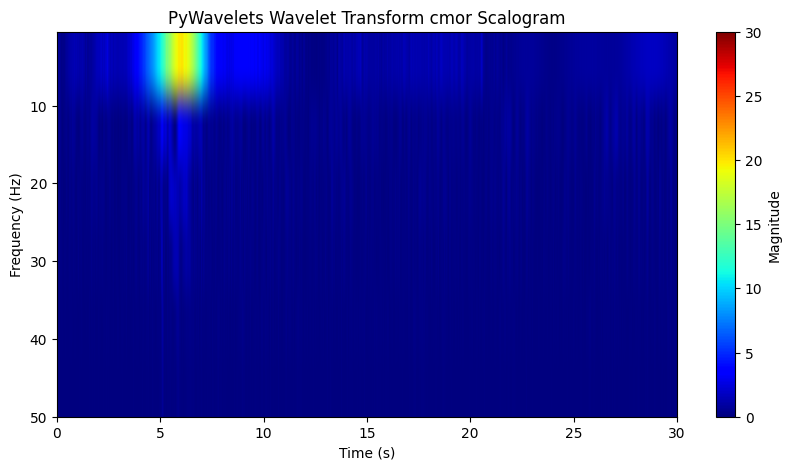

In [177]:
# for all the wavelet families do the wavelet transform of the eeg signal and plot the coefficients
fs = 100  # Sampling frequency of the signal

# Frequency bands of interest based on sleep staging
freqs = np.array([0.5, 4, 8, 13, 30, 50])  # Hz

# scales = np.linspace(1, 64, 50) # Scales for the WT to prevent kernel crash
# Wavelet center frequency
# fc = pywt.central_frequency('cmor')
# # print(f"Wavelet: {wavelet}, Central frequency: {fc} Hz")

# # Convert frequencies to scales
# scales = fc * fs / (freqs)
# print(scales)

for family in pywt.families():
    if family in cont_families:
        wavelet = pywt.wavelist(family)[0]
        # Wavelet center frequency
        fc = pywt.central_frequency(wavelet)
        print(f"Wavelet: {wavelet}, Central frequency: {fc} Hz")

        # Convert frequencies to scales
        scales = fc * fs / (freqs)
        print(scales)

        coeffs, freq = compute_cwt(seq[0].numpy(), fs, scales, wavelet)
        plot_cwt(coeffs, freq, wavelet=wavelet)

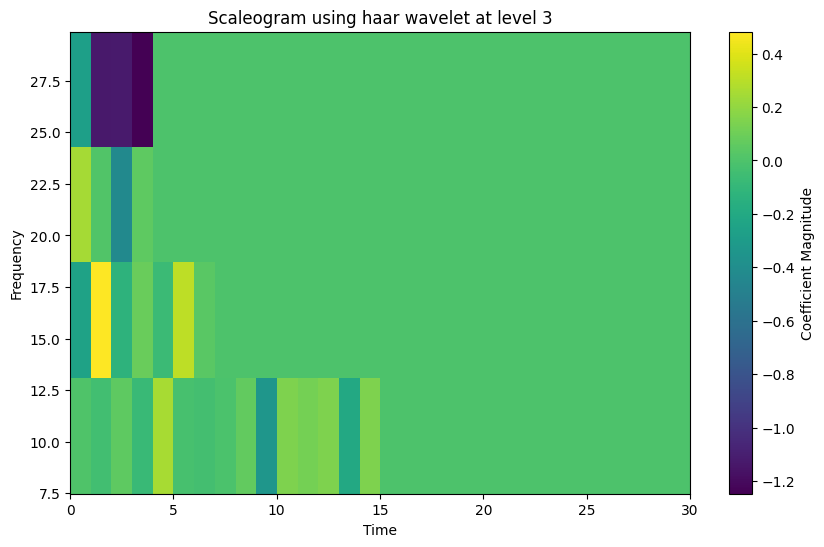

In [141]:
coeffs = compute_dwt(seq[0].numpy(), "haar")
plot_scaleogram(coeffs, "haar")

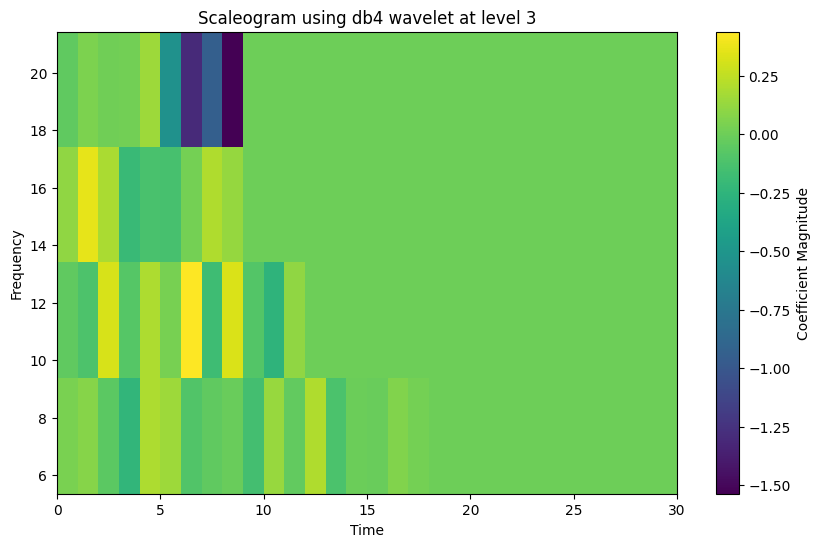

In [142]:
coeffs = compute_dwt(seq[0].numpy(), "db4")
plot_scaleogram(coeffs, "db4")

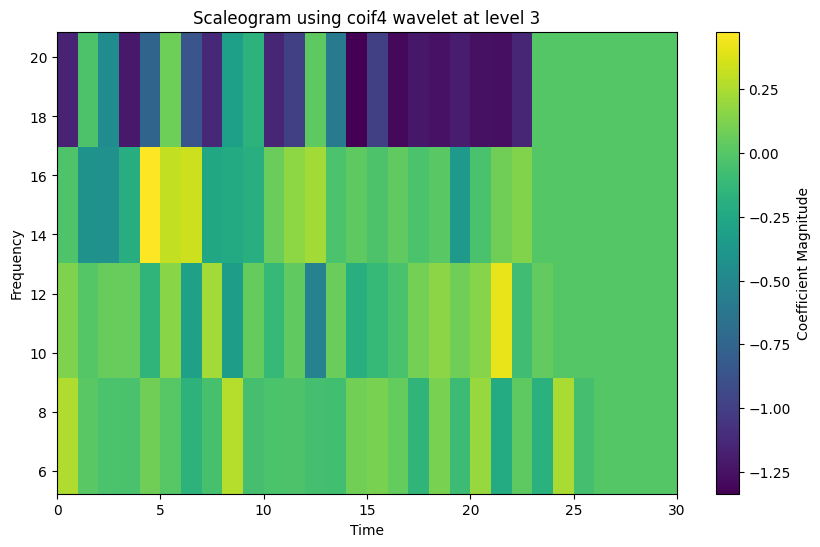

In [143]:
coeffs = compute_dwt(seq[0].numpy(), "coif4")
plot_scaleogram(coeffs, "coif4")